# Simple RAG for the AI index report using Hugging Face Zephyr and LangChain

Report: https://aiindex.stanford.edu/report/

# Installation

In [ ]:
!pip install -q torch
!pip install -q transformers
!pip install -q accelerate
!pip install -q bitsandbytes
!pip install -q sentence-transformers
!pip install -q faiss-cpu
!pip install -q langchain
!pip install -q langchain-community
!python -m pip install pypdf

# Imports

In [3]:
import os

from urllib.request import urlretrieve

from langchain_community.document_loaders import PyPDFDirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings

In [4]:
import torch

from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

from langchain.llms import HuggingFacePipeline
from langchain.prompts import PromptTemplate
from transformers import pipeline
from langchain_core.output_parsers import StrOutputParser

from langchain_core.runnables import RunnablePassthrough

In [5]:
import time

# Create the embeddings + retriever


In [9]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS

embedding_models = {
    "MiniLM": 'sentence-transformers/all-MiniLM-L6-v2',
    "BGE": 'BAAI/bge-base-en-v1.5',
    "E5-multilingual": 'intfloat/multilingual-e5-large'
}

vectorstores = {}

for name, model_name in embedding_models.items():
    print(f"Створюємо індекс для моделі: {name}")
    embeddings = HuggingFaceEmbeddings(model_name=model_name)
    vectorstore = FAISS.from_documents(docs_after_split, embeddings)
    vectorstores[name] = vectorstore

Створюємо індекс для моделі: MiniLM


/tmp/ipython-input-9-165844166.py:14: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name=model_name)
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Створюємо індекс для моделі: BGE
Створюємо індекс для моделі: E5-multilingual


In [10]:
vectorstores["MiniLM"]
# vectorstores["BGE"]
# vectorstores["E5-multilingual"]

# Load LM


In [ ]:
model_name = 'HuggingFaceH4/zephyr-7b-beta'

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb_config)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Setup the LLM chain


In [12]:
!pip install -U langchain

In [16]:
from langchain.schema.runnable import RunnableMap, RunnablePassthrough
from langchain.prompts import PromptTemplate
from langchain_community.llms import HuggingFacePipeline
from transformers import pipeline

text_generation_pipeline = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    temperature=0.2,
    do_sample=True,
    repetition_penalty=1.1,
    return_full_text=True,
    max_new_tokens=400,
)

llm = HuggingFacePipeline(pipeline=text_generation_pipeline)
prompt_template = """
<|system|>
Answer the question based on your knowledge. Use the following context to help:

{context}

</s>
<|user|>
{question}
</s>
<|assistant|>
"""

prompt = PromptTemplate(
    input_variables=["context", "question"],
    template=prompt_template,
)

llm_chain = prompt | llm

qa_chains = {}

for name, vectorstore in vectorstores.items():
    retriever = vectorstore.as_retriever()
    qa_chain = RunnableMap({
        "question": lambda x: x["question"],
        "context": lambda x: retriever.invoke(x["question"]),
    }) | llm_chain
    qa_chains[name] = qa_chain

Device set to use cuda:0


In [17]:
question1 = "How would you describe the statistics on ChatGPT usage among teachers and students?"
question2 = "What impact will artificial intelligence have on the labor market over the next five years?"
question3 = "How can artificial intelligence help speed up medical discoveries and improve diagnostic accuracy?"
question4 = "How do recent advances in artificial intelligence affect innovation in science?"

In [18]:
questions = {
    "Q1": question1,
    "Q2": question2,
    "Q3": question3,
    "Q4": question4,
}

for q_id, question in questions.items():
    print(f"\n========================")
    print(f"❓ {q_id}: {question}")
    for model_name, chain in qa_chains.items():
        print(f"\n📌 Модель ембедінгів: {model_name}")
        result = chain.invoke({"question": question})
        print(result)



❓ Q1: How would you describe the statistics on ChatGPT usage among teachers and students?

📌 Модель ембедінгів: MiniLM

<|system|>
Answer the question based on your knowledge. Use the following context to help:

[Document(id='cfb053fd-67ce-431a-b112-a420458feff5', metadata={'producer': 'Adobe PDF Library 17.0', 'creator': 'Adobe InDesign 20.3 (Macintosh)', 'creationdate': '2025-05-26T11:07:48-07:00', 'author': 'Nestor Maslej', 'moddate': '2025-05-29T11:32:45-07:00', 'subject': 'Welcome to the eighth edition of the AI Index report. The 2025 Index is our most comprehensive to date and arrives at an important moment, as AI’s influence across society, the economy, and global governance continues to intensify. New in this year’s report are in-depth analyses of the evolving landscape of AI hardware, novel estimates of inference costs, and new analyses of AI publication and patenting trends. We also introduce fresh data on corporate adoption of responsible AI practices, along with expanded c

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



<|system|>
Answer the question based on your knowledge. Use the following context to help:

[Document(id='6e187db1-2561-416a-9f07-bd93054b7052', metadata={'producer': 'Adobe PDF Library 17.0', 'creator': 'Adobe InDesign 20.3 (Macintosh)', 'creationdate': '2025-05-26T11:07:48-07:00', 'author': 'Nestor Maslej', 'moddate': '2025-05-29T11:32:45-07:00', 'subject': 'Welcome to the eighth edition of the AI Index report. The 2025 Index is our most comprehensive to date and arrives at an important moment, as AI’s influence across society, the economy, and global governance continues to intensify. New in this year’s report are in-depth analyses of the evolving landscape of AI hardware, novel estimates of inference costs, and new analyses of AI publication and patenting trends. We also introduce fresh data on corporate adoption of responsible AI practices, along with expanded coverage of AI’s growing role in science and medicine. Since its founding in 2017 as an offshoot of the One Hundred Year 


===== Q1: How would you describe the statistics on ChatGPT usage among teachers and students?

 MiniLM:

<|system|>
Answer the question based on your knowledge. Use the following context to help:

[Document(id='cfb053fd-67ce-431a-b112-a420458feff5', metadata={'producer': 'Adobe PDF Library 17.0', 'creator': 'Adobe InDesign 20.3 (Macintosh)', 'creationdate': '2025-05-26T11:07:48-07:00', 'author': 'Nestor Maslej', 'moddate': '2025-05-29T11:32:45-07:00', 'subject': 'Welcome to the eighth edition of the AI Index report. The 2025 Index is our most comprehensive to date and arrives at an important moment, as AI’s influence across society, the economy, and global governance continues to intensify. New in this year’s report are in-depth analyses of the evolving landscape of AI hardware, novel estimates of inference costs, and new analyses of AI publication and patenting trends. We also introduce fresh data on corporate adoption of responsible AI practices, along with expanded coverage of AI’s

<Figure size 1000x600 with 0 Axes>

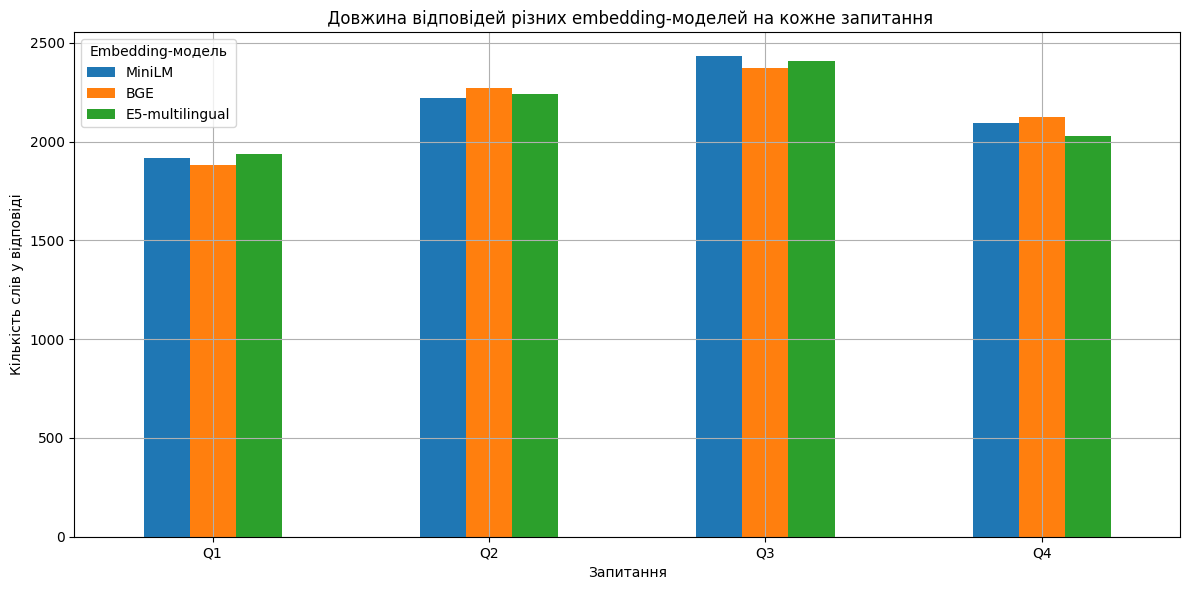

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

results_by_model = {}

for model_name in qa_chains.keys():
    results_by_model[model_name] = []

for q_id, question in questions.items():
    print(f"\n===== {q_id}: {question}")
    for model_name, chain in qa_chains.items():
        result = chain.invoke({"question": question})
        answer = result if isinstance(result, str) else str(result)
        print(f"\n {model_name}:\n{answer}")
        results_by_model[model_name].append(len(answer.split()))

df = pd.DataFrame(results_by_model, index=questions.keys())

plt.figure(figsize=(10, 6))
df.plot(kind='bar', figsize=(12, 6))
plt.title(" Довжина відповідей різних embedding-моделей на кожне запитання")
plt.xlabel("Запитання")
plt.ylabel("Кількість слів у відповіді")
plt.xticks(rotation=0)
plt.legend(title="Embedding-модель")
plt.tight_layout()
plt.grid(True)
plt.show()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


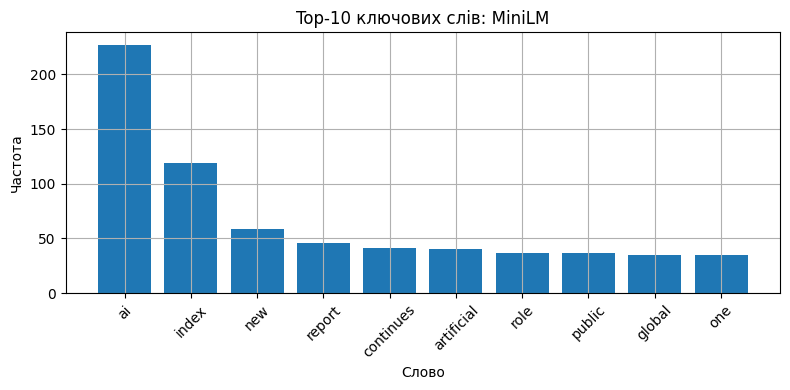

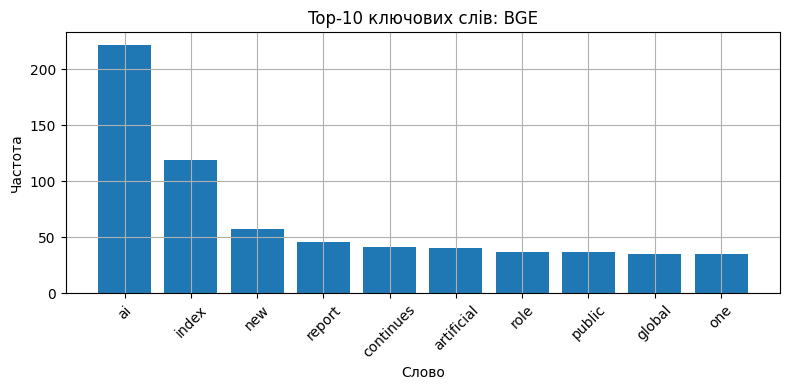

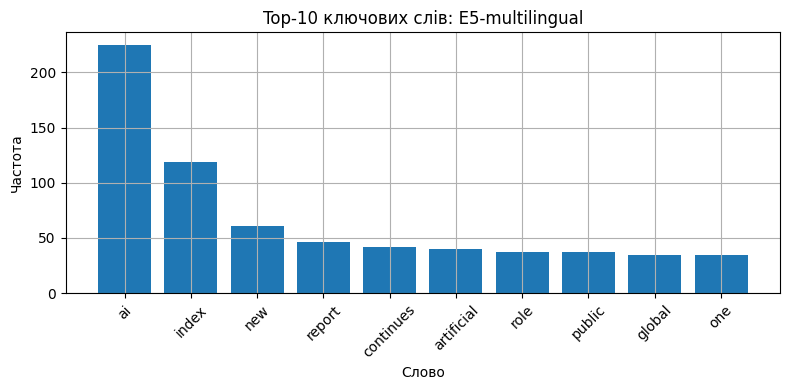

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import nltk
import string
nltk.download("stopwords")
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english") + list(string.punctuation))
all_answers = {model_name: "" for model_name in qa_chains.keys()}

for q_id, question in questions.items():
    for model_name, chain in qa_chains.items():
        result = chain.invoke({"question": question})
        answer = result if isinstance(result, str) else str(result)
        all_answers[model_name] += " " + answer.lower()

for model_name, text in all_answers.items():
    words = text.split()
    words_filtered = [word.strip(string.punctuation) for word in words if word.lower() not in stop_words and word.isalpha()]
    word_freq = Counter(words_filtered).most_common(10)
    words, freqs = zip(*word_freq)
    plt.figure(figsize=(8, 4))
    plt.bar(words, freqs)
    plt.title(f"Top-10 ключових слів: {model_name}")
    plt.ylabel("Частота")
    plt.xlabel("Слово")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()